Préparation des bibliothéques

In [ ]:
import pandas as pd
import re
from collections import defaultdict
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

Upload des fichiers sur collab

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df_raw = pd.read_excel(file_name, header=None)

print("Shape:", df_raw.shape)
display(df_raw.head(10))


Saving BMGs-2024(1).xlsx to BMGs-2024(1) (2).xlsx
Shape: (353, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Alloys (compostion),Tg(K),Tx(K),Tl(K),Dmax (mm),NaN,Alloys,Tg(K),Tx(K),Tl(K),Dmax (mm)
3,NaN,Ag30.8 Ca30.8 Mg23.1 Cu15.4,413,432,803,2.5,NaN,Ag30.8 Mg30.8 Ca30.8 Cu7.7,407,427,809,2
4,NaN,Ag38.4 Mg30.8 Ca30.8,394,426,805,0.5,NaN,Ag38.4 Mg38.4 Ca23.2,391,425,796,1.1
5,NaN,Ag38.5 Ca30.8 Mg23 Cu7.7,384,416,854,2,NaN,Ag38.5 Mg30.8 Ca23.1 Cu7.7,387,420,833,3
6,NaN,Ag38.5 Mg38.5 Ca15.4 Cu7.7,405,436,842,0.5,NaN,Ag46.2 Ca30.5 Mg15.4 Cu7.7,414,445,805,0.8
7,NaN,Ag46.2 Ca30.7 Mg23.1,399,426,765,0.7,NaN,Ag46.2 Ca38.4 Mg15.3,407,439,809,0.3
8,NaN,Ag46.2 Mg23.2 Ca23 Cu7.7,398,430,825,2,NaN,Ag46.2 Mg30.7 Ca23.1,393,427,880,0.5
9,NaN,Ag50 Ca30.8 Mg11.5 Cu7.7,452,487,809,1,NaN,Ag50 Ca30.8 Mg19.2 Cu7.7,426,466,797,1.2


Alignement des lignes et colonnes

In [ ]:

df1 = df_raw.iloc[:, 1:6]
df1.columns = ["Alloys (composition)", "Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]


df2 = df_raw.iloc[:, 7:12]
df2.columns = ["Alloys (composition)", "Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]

df1 = df1.drop(index=0).reset_index(drop=True)
df2 = df2.drop(index=0).reset_index(drop=True)


df_combined = pd.concat([df1, df2], ignore_index=True)
rows_to_drop = [0,1,353]
df_combined = df_combined.drop(index=rows_to_drop).reset_index(drop=True)
df_combined.dropna(subset=["Alloys (composition)"], inplace=True)

df_combined.reset_index(drop=True, inplace=True)


df_combined.to_csv("cleaned_alloys.csv", index=False)
print(" saved to 'cleaned_alloys.csv'")

print(f" Cleaned dataset with {len(df_combined)} entries:")
display(df_combined.head())



 saved to 'cleaned_alloys.csv'
 Cleaned dataset with 698 entries:


,Alloys (composition),Tg(K),Tx(K),Tl(K),Dmax (mm)
0,Ag30.8 Ca30.8 Mg23.1 Cu15.4,413,432,803,2.5
1,Ag38.4 Mg30.8 Ca30.8,394,426,805,0.5
2,Ag38.5 Ca30.8 Mg23 Cu7.7,384,416,854,2
3,Ag38.5 Mg38.5 Ca15.4 Cu7.7,405,436,842,0.5
4,Ag46.2 Ca30.7 Mg23.1,399,426,765,0.7


Chargement du CSV

In [ ]:
df_raw = pd.read_csv("cleaned_alloys.csv")


Vérification du nom de la colonne

In [ ]:

df_raw.columns = [col.strip() for col in df_raw.columns]
if "Alloys (compostion)" in df_raw.columns:
    df_raw = df_raw.rename(columns={"Alloys (compostion)": "Alloys (composition)"})


Ajoute des élements valide

In [ ]:
# Step 3: Element verification set
valid_elements = {
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S",
    "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga",
    "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd",
    "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm",
    "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os",
    "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa",
    "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg",
    "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
}

Ajout des Regex patterns

In [ ]:
# Patterns

element_pattern = re.compile(r'([A-Z][a-z]?)(\d*\.?\d*)')
group_pattern = re.compile(r'\(([^()]+)\)(\d*\.?\d*)')


Fonction pour découpé les élemnts des lignes


In [ ]:
def parse_group(text, outer_fraction):

    inner_elements = element_pattern.findall(text)
    result = defaultdict(float)
    temp_vals = {}


    for el, pct in inner_elements:
        if el not in valid_elements:
            raise ValueError(f"Invalid element '{el}' in group: ({text})")
        pct_val = float(pct or 0.0)
        temp_vals[el] = pct_val


    total_inner = sum(temp_vals.values())
    if 0.95 <= total_inner <= 1.05:

        for el in temp_vals:
            temp_vals[el] *= 100


    for el, val in temp_vals.items():
        result[el] += val * outer_fraction / 100.0

    return result


Découpage des lignes

In [ ]:
def parse_line(line, original_line):
    composition = defaultdict(float)
    try:
        while '(' in line:
            match = group_pattern.search(line)
            if not match:
                break
            group_text, group_pct = match.groups()
            group_pct = float(group_pct or 1.0)
            group_contrib = parse_group(group_text, group_pct)
            for el, val in group_contrib.items():
                composition[el] += val
            line = line[:match.start()] + line[match.end():]

        for el, val in element_pattern.findall(line):
            if el not in valid_elements:
                raise ValueError(f"Invalid element '{el}'")
            composition[el] += float(val or 0.0)

        return composition

    except ValueError as ve:
        print(f" Error in line: '{original_line}' -> {ve}")
        invalid_lines.append(original_line)
        return None


Application des deux fonctions précedentes


In [ ]:
invalid_lines = []
parsed_data = []
for i, row in df_raw.iterrows():
    comp_str = str(row["Alloys (composition)"])
    result = parse_line(comp_str, comp_str)
    if result:
        parsed_data.append(result)


all_elements = sorted({el for comp in parsed_data for el in comp})

composition_df = pd.DataFrame([{el: comp.get(el, 0.0) for el in all_elements} for comp in parsed_data])

meta_columns = ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]
meta_df = df_raw.loc[composition_df.index, meta_columns].reset_index(drop=True)
final_df = pd.concat([composition_df, meta_df], axis=1)

 Error in line: 'Fe58 MoB111:L14514 C15 B6 Cr5 Er2' -> Invalid element 'L'
 Error in line: 'Mg61 Cu29G d10' -> Invalid element 'G'
 Error in line: 'Mm51.2 Al23.2 Cu9.3 Ni9.3 C7' -> Invalid element 'Mm'


Sauvgarde du CSV

In [ ]:
print(" Final dataset:")
display(final_df.head())

final_df.to_csv("parsed_alloy_data.csv", index=False)
print(" Saved as parsed_alloy_data.csv")

 Final dataset:


,Ag,Al,Au,B,Be,C,Ca,Ce,Co,Cr,...,Tm,V,W,Y,Zn,Zr,Tg(K),Tx(K),Tl(K),Dmax (mm)
0,30.8,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,413.0,432.0,803.0,2.5
1,38.4,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,394.0,426.0,805.0,0.5
2,38.5,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,384.0,416.0,854.0,2.0
3,38.5,0.0,0.0,0.0,0.0,0.0,15.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,405.0,436.0,842.0,0.5
4,46.2,0.0,0.0,0.0,0.0,0.0,30.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,399.0,426.0,765.0,0.7


 Saved as parsed_alloy_data.csv


Suppression des valeurs vides

In [ ]:

meta_cols = ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]


missing_mask = final_df[meta_cols].isnull().any(axis=1)

if missing_mask.any():
    print(f" {missing_mask.sum()} rows have missing or NaN values in {meta_cols}")

    final_df = final_df.loc[~missing_mask].reset_index(drop=True)
else:
    print(" No missing or NaN values found in the meta columns.")

print("Final cleaned dataset:")
display(final_df.head())


 No missing or NaN values found in the meta columns.
Final cleaned dataset:


,Ag,Al,Au,B,Be,C,Ca,Ce,Co,Cr,...,Tm,V,W,Y,Zn,Zr,Tg(K),Tx(K),Tl(K),Dmax (mm)
0,30.8,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,413.0,432.0,803.0,2.5
1,38.4,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,394.0,426.0,805.0,0.5
2,38.5,0.0,0.0,0.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,384.0,416.0,854.0,2.0
3,38.5,0.0,0.0,0.0,0.0,0.0,15.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,405.0,436.0,842.0,0.5
4,46.2,0.0,0.0,0.0,0.0,0.0,30.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,399.0,426.0,765.0,0.7


Vérification des pourcentage max est 100%

In [ ]:

tolerance = 0.15
valid_indices = []
dropped_rows = []

for idx, comp in enumerate(parsed_data):
    total = sum(comp.values())
    if total <= 100 + tolerance:
        valid_indices.append(idx)
    else:
        dropped_rows.append((idx, total))

composition_df = composition_df.loc[valid_indices].reset_index(drop=True)
final_df = final_df.loc[valid_indices].reset_index(drop=True)

if dropped_rows:
    print(f"\n Dropped {len(dropped_rows)} rows with > {100 + tolerance}% total composition:")
    for idx, total in dropped_rows:
        print(f" - Row {idx} had {total:.2f}%")
else:
    print("\n All rows are within the valid composition range.")



 Dropped 32 rows with > 100.15% total composition:
 - Row 59 had 104.00%
 - Row 124 had 104.00%
 - Row 128 had 106.00%
 - Row 129 had 104.00%
 - Row 130 had 107.00%
 - Row 131 had 105.00%
 - Row 132 had 105.00%
 - Row 133 had 105.00%
 - Row 149 had 104.00%
 - Row 169 had 100.96%
 - Row 185 had 104.00%
 - Row 187 had 106.00%
 - Row 261 had 104.00%
 - Row 267 had 104.00%
 - Row 268 had 104.00%
 - Row 338 had 115.00%
 - Row 354 had 107.70%
 - Row 372 had 110.00%
 - Row 404 had 104.00%
 - Row 405 had 104.00%
 - Row 470 had 106.00%
 - Row 476 had 106.00%
 - Row 477 had 108.00%
 - Row 478 had 106.00%
 - Row 479 had 106.00%
 - Row 480 had 105.00%
 - Row 481 had 104.00%
 - Row 496 had 106.00%
 - Row 532 had 106.00%
 - Row 535 had 104.00%
 - Row 576 had 100.35%
 - Row 617 had 104.00%


Check des outliers

In [ ]:
meta_cols = ["Tg(K)", "Tx(K)", "Tl(K)"]

outlier_indices = set()

for col in meta_cols:
    col_values = final_df[col]
    mean = col_values.mean()
    std = col_values.std()

    z_scores = (col_values - mean) / std
    outliers = final_df[(z_scores > 3) | (z_scores < -3)].index
    outlier_indices.update(outliers)

print(f"Found {len(outlier_indices)} outlier rows based on Z-score method across {meta_cols}.")

outlier_rows = final_df.loc[list(outlier_indices)]
print(outlier_rows[meta_cols])

final_df = final_df.drop(index=outlier_indices).reset_index(drop=True)
composition_df_clean = composition_df.drop(index=outlier_indices).reset_index(drop=True)



Found 0 outlier rows based on Z-score method across ['Tg(K)', 'Tx(K)', 'Tl(K)'].
Empty DataFrame
Columns: [Tg(K), Tx(K), Tl(K)]
Index: []


Normalisation

In [ ]:
X = final_df[["Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


KMeans

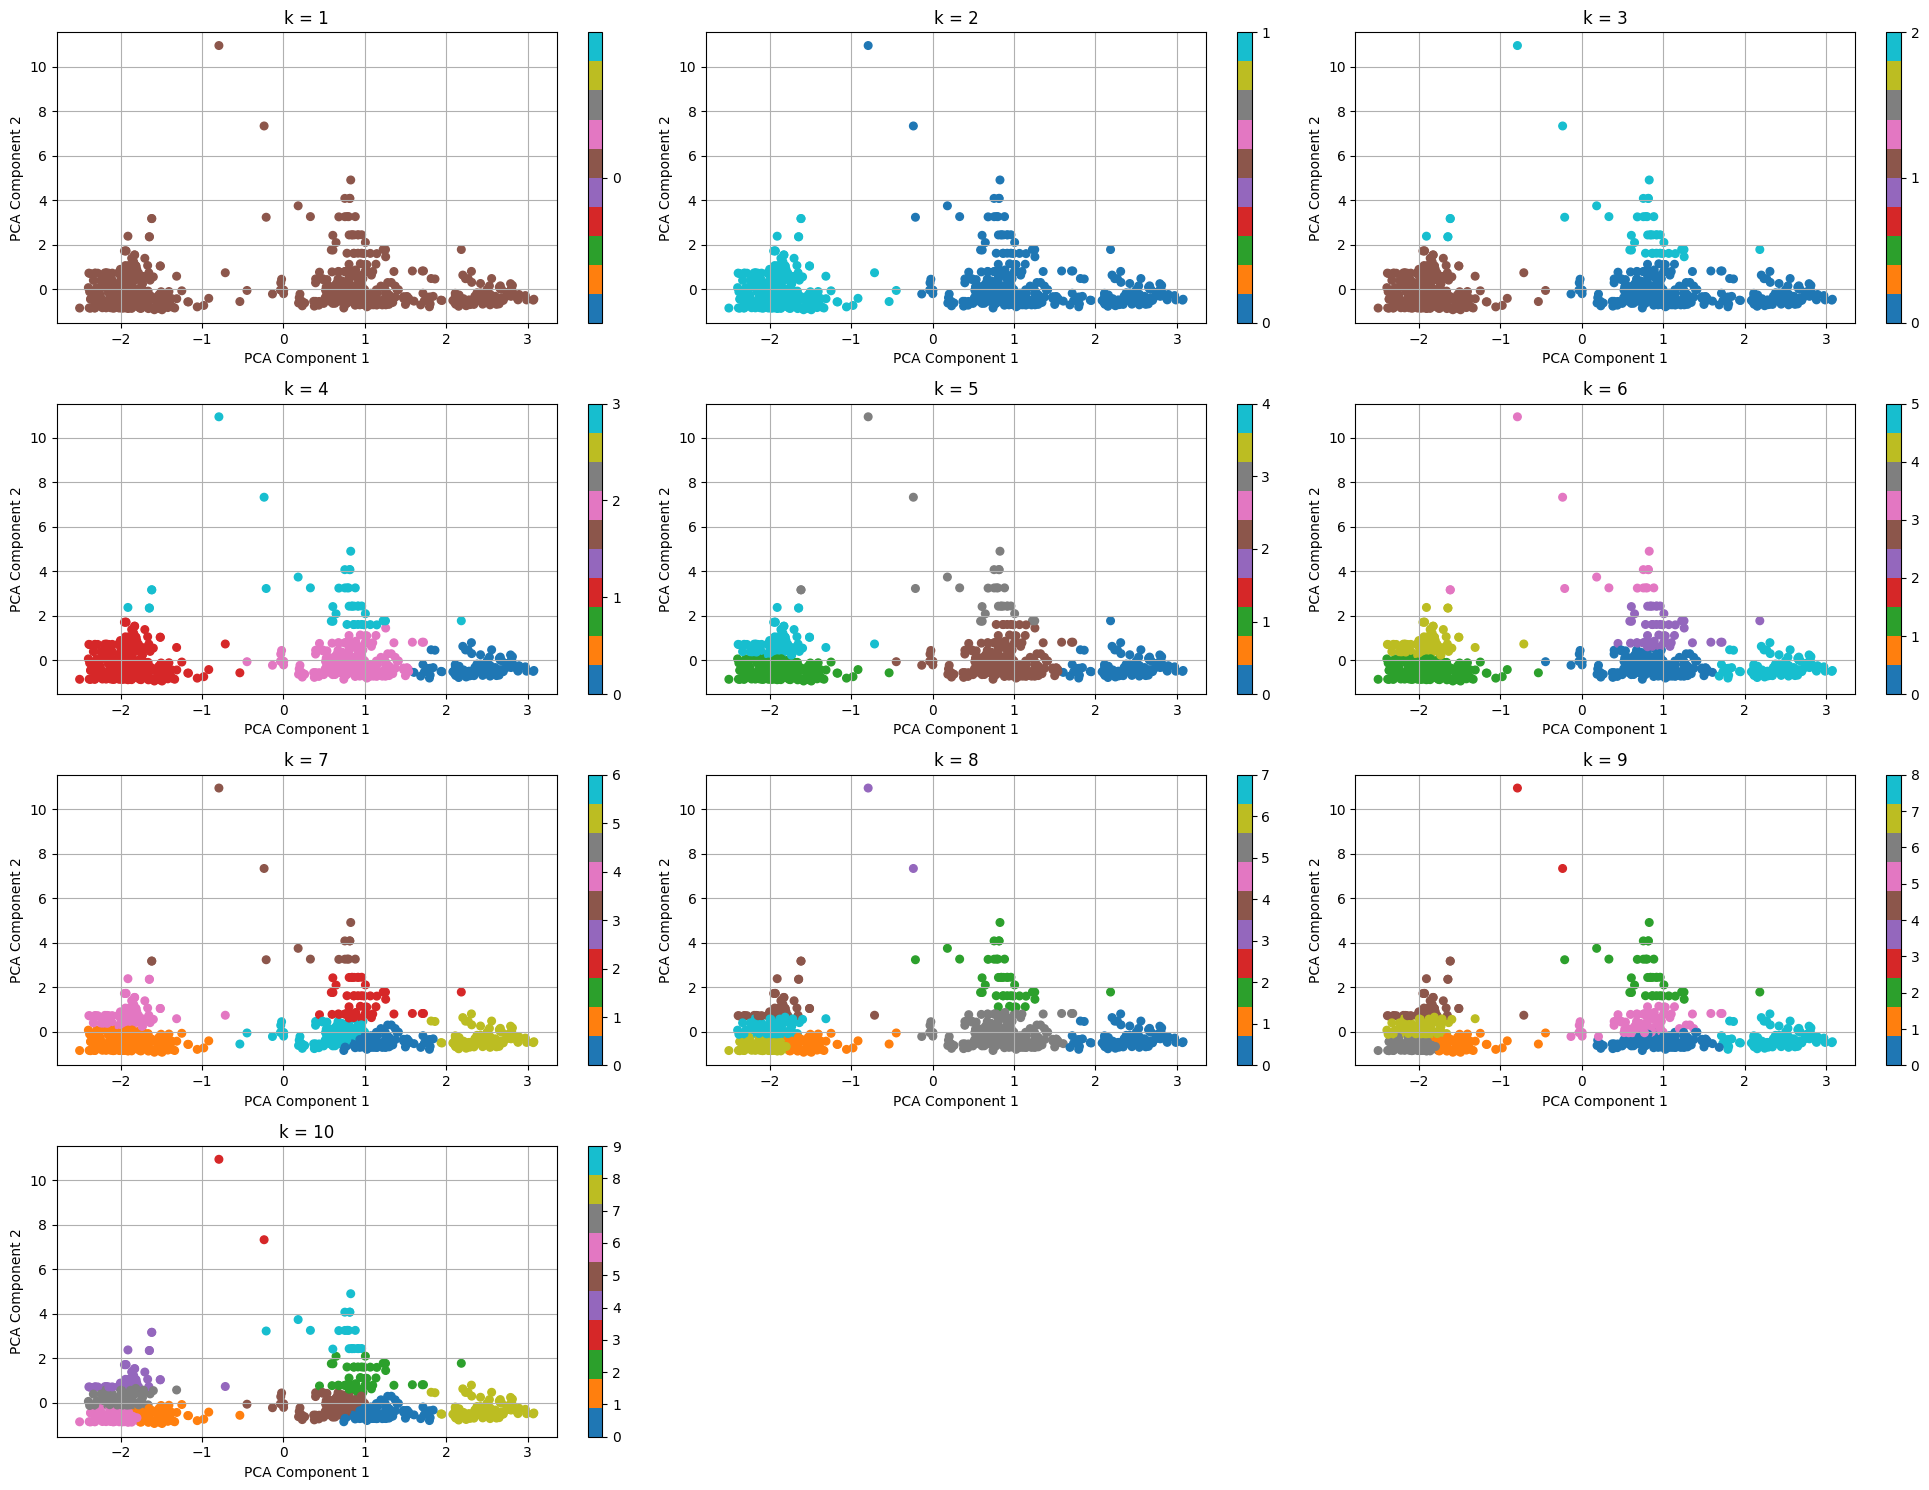

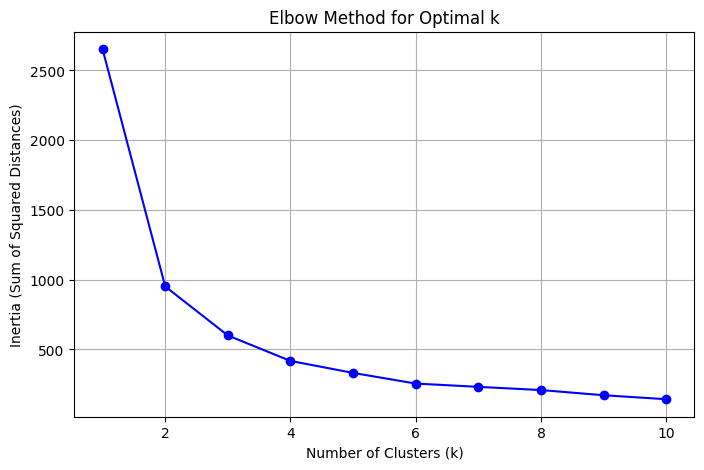

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Elbow method inertia list
inertia_values = []
K_range = range(1, 11)

plt.figure(figsize=(20, 15))

for i, k in enumerate(K_range, 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia_values.append(kmeans.inertia_)


    plt.subplot(4, 3, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=30)
    plt.title(f'k = {k}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    if k <= 10:
        plt.colorbar(scatter, ticks=range(k))

plt.tight_layout()
plt.show()

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


Shilhouette scores

Silhouette score for k=2: 0.6237
Silhouette score for k=3: 0.6437
Silhouette score for k=4: 0.5804
Silhouette score for k=5: 0.5087
Silhouette score for k=6: 0.5195
Silhouette score for k=7: 0.4547
Silhouette score for k=8: 0.4451
Silhouette score for k=9: 0.3919
Silhouette score for k=10: 0.3826


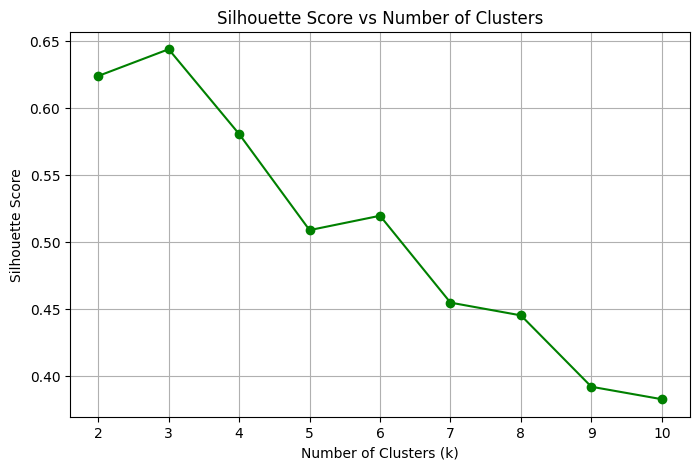

In [ ]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia_values.append(kmeans.inertia_)


    if k > 1:
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
        print(f"Silhouette score for k={k}: {score:.4f}")
    else:
        silhouette_scores.append(None)


plt.figure(figsize=(8,5))
plt.plot(list(K_range)[1:], silhouette_scores[1:], 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()



 Meilleur k basé sur le Silhouette Score : 3


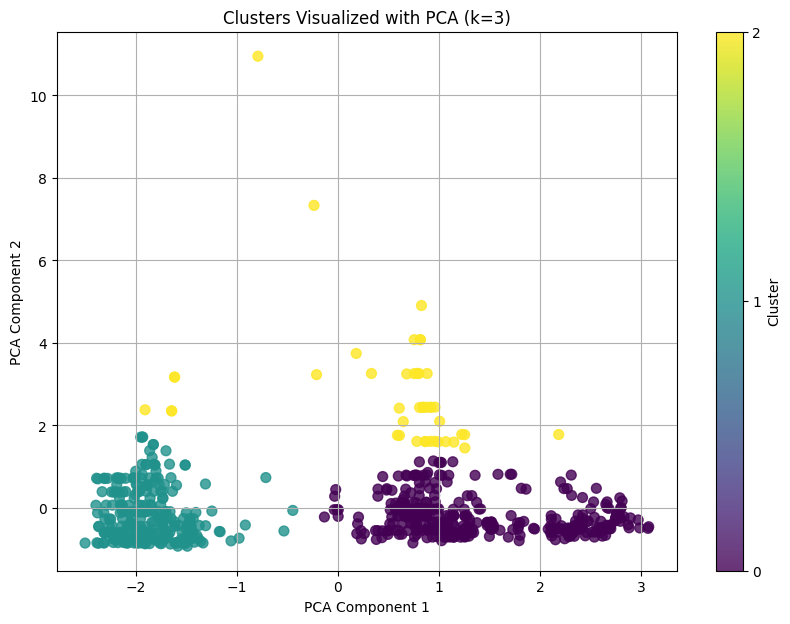

In [ ]:

best_k = K_range[silhouette_scores.index(max([s for s in silhouette_scores if s is not None]))]
print(f"\n Meilleur k basé sur le Silhouette Score : {best_k}")
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

X_scaled_df = pd.DataFrame(X_scaled, columns=["Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"])
X_scaled_df['Cluster'] = labels

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Clusters Visualized with PCA (k={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, ticks=range(best_k), label='Cluster')
plt.grid(True)
plt.show()


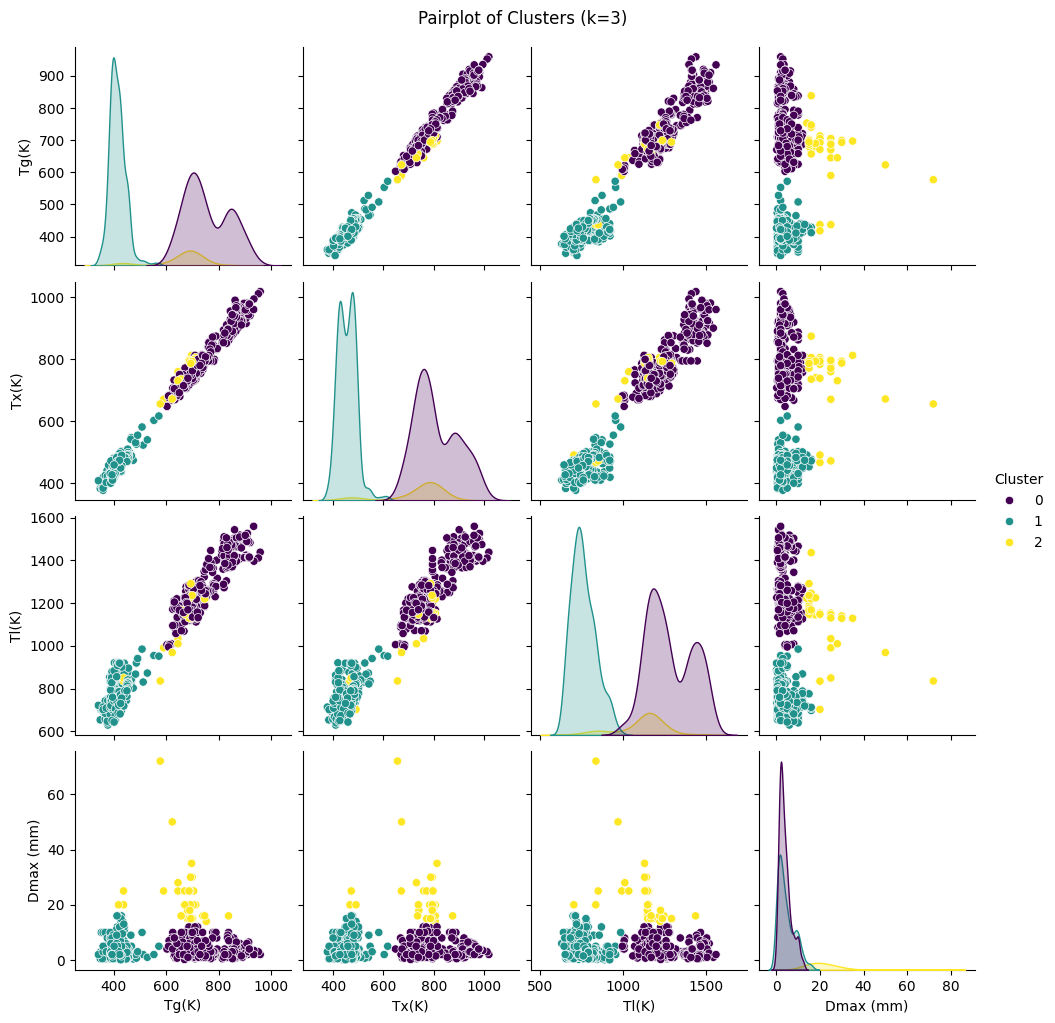

In [ ]:

features_to_plot = ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax (mm)"]

final_df_with_clusters = final_df.copy()
final_df_with_clusters['Cluster'] = labels

sns.pairplot(final_df_with_clusters, vars=features_to_plot, hue='Cluster', palette='viridis')
plt.suptitle(f'Pairplot of Clusters (k={best_k})', y=1.02)
plt.show()

Dendrogramme hiérarchique

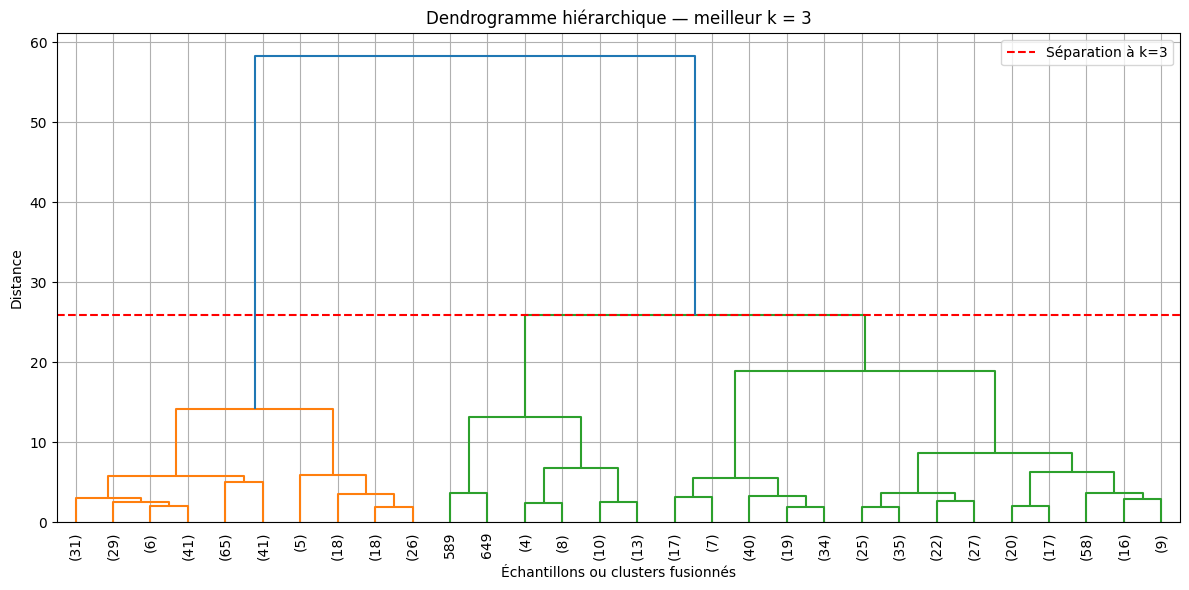

In [ ]:
linked = sch.linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title(f'Dendrogramme hiérarchique — meilleur k = {best_k}')
plt.xlabel('Échantillons ou clusters fusionnés')
plt.ylabel('Distance')
plt.axhline(y=linked[-(best_k-1), 2], c='red', linestyle='--', label=f'Séparation à k={best_k}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
